In [68]:
%matplotlib inline
import torch
import torchvision
import math
import seaborn as sns
import pandas as pd

In [2]:
import sys
sys.path.append('..')

In [70]:
from train import cifar_stats

In [3]:
path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit.pkl'

In [4]:
model = torch.load(path, map_location=torch.device('cpu'))

In [15]:
params = [(layer._quadratic.weight, layer.weight, layer.bias) 
           for layer in model.features if hasattr(layer, '_quadratic')]

In [16]:
(qw, w, b), = params
fan_in = w.shape[1] # this is to accommodate my initial incorrect implementation

In [58]:
qw.shape

torch.Size([512, 27])

Recall that the net input is calculated as:

$z = \alpha_t \sum_{i=1}^m w^\prime_i x_i^2 + \alpha_t \gamma + \sum_{i=1}^m w_i x_i + b,$

where $\{w^\prime_i\}$ (called quadratic weights here) are constrained to be negative, $\alpha_t=1$ when training is finished, and $\gamma = \sqrt{\text{fan-in}}$.

We rewrite the formula into:

$z = \sum_{i=1}^m w^\prime_i \left(x_i + \frac{w_i}{2w^\prime_i} \right)^2 \underbrace{- \frac{1}{4} \left( \frac{w_i}{w^\prime_i} \right)^2 + \sqrt{\text{fan-in}} + b}_{b_0},$

In [52]:
w = w.reshape(w.shape[0],-1)
qw = qw.reshape(w.shape[0],-1)
b0 = -0.25*torch.sum((w/qw)**2, axis=1) + math.sqrt(fan_in) + b

In [61]:
radii = torch.sqrt((qw * b0.reshape(b0.shape[0],1)).abs()).flatten().detach()

In [62]:
radii.mean().item(), radii.std().item()

(9.678997039794922, 75.04656219482422)

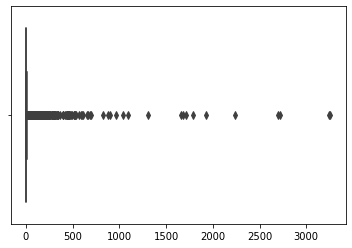

In [63]:
_ = sns.boxplot(radii)

In [65]:
radii_series = pd.Series(radii)
radii_series.describe()

count    13824.000000
mean         9.678996
std         75.046562
min          0.000417
25%          0.103802
50%          0.532536
75%          3.703169
max       3257.342773
dtype: float64

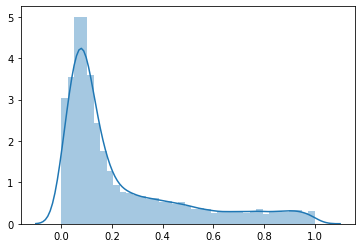

In [67]:
_ = sns.distplot(radii_series[radii_series < 1])

# Compare to input distribution

In [71]:
transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*cifar_stats)
])
cifar10_testset = torchvision.datasets.CIFAR10(root='../cifar10', train=False, download=False, transform=transform_test)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=256, shuffle=False, num_workers=2)

In [72]:
x, y = next(iter(cifar10_testloader))

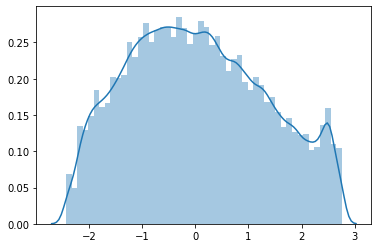

In [73]:
sns.distplot(x.flatten())